In [5]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.similarity import graph_edit_distance
import math
import statistics
warnings.filterwarnings("ignore")


In [2]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [3]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [6]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [7]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls =2  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.3))
    return km.to_nx(graph)

In [10]:
def calc_average_for_hop(hop,ref_graph,n,p,k,delta_n,delta_p,delta_k):
    original = []
    TDA =[]
    
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            for t in range(-hop,hop+1):
                if (i == -hop or i == hop or j == -hop or j == hop or t == hop or t == -hop):
                    neighbour = nx.watts_strogatz_graph(i*delta_n + n,k + delta_k *t,j*delta_p + p)

                    TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                    TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))

                    score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                    score_original = calculate_similarity(ref_graph, neighbour)

                    original.append(score_original)
                    TDA.append(score_TDA)
    return {"hop" : hop,"TDA": statistics.median(TDA),"original": statistics.median(original),"TDA-list" : TDA,"original-list":original}
                

In [9]:
def conduct_test_for_on_graph(graph,n,k,p,delta_n,delta_p,delta_k,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,k = k,p=p,delta_n = delta_n,delta_p = delta_p,delta_k=delta_k)
    return {"n" : n,"k" : k,"p":p,"Result" : result}

In [11]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('k')
    column.append('p')

    detail_row_list = []
    detail_column = ['Sample','Replication', 'n','k','p','Hop','Neigbour Index','Original','TDA']
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
    
    counter = 1
    for i in range(sample_numbers):
        n = random.randint(100,1000)       
        p = round(random.uniform(21, 80))/100
        k = random.randint(5,8)
        for t in range(5):
            row =[]

            row.append(n)
            row.append(k)
            row.append(p)
            reference_graph = nx.watts_strogatz_graph(n,k,p)
            result = conduct_test_for_on_graph(graph = reference_graph,n = n,k = k,p = p,delta_n = 5,delta_p = 0.05 ,delta_k = 1,n_hop = 4)['Result']


            for j in range(n_hop):
                row.append(result[j]['original'])
                row.append(result[j]['TDA'])
                
                TDA_list = result[j]['TDA-list']
                original_list = result[j]['original-list']
                for m in range(len(TDA_list)):
                    detail_row = []
                    detail_row.append(i+1)
                    detail_row.append(t + 1)
                    detail_row.append(n)
                    detail_row.append(k)
                    detail_row.append(p)
                    detail_row.append(j+1)
                    detail_row.append(str(m+1))
                    detail_row.append(round(original_list[t],2))
                    detail_row.append(round(TDA_list[t],2))
                    detail_row_list.append(detail_row)
            row_list.append(row)
            print("Done:" + str(counter) + "/" +  str(sample_numbers * 5))
            counter += 1
       
    df = pd.DataFrame(row_list,columns= column)
    df_detail = pd.DataFrame(detail_row_list,columns=detail_column)
    result = {"result" : df, "detail" : df_detail}
    return result

In [27]:
result = conduct_test_on_sample(1,4)
result

Done:1/5


KeyboardInterrupt: 

In [28]:
result.to_csv("WS")

AttributeError: 'dict' object has no attribute 'to_csv'

In [6]:
original_average =[]
TDA_avaerage = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = result[original_text].tolist()
    tda_list = result[TDA_text].tolist()
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
    #original_average.append(round(math.log10(original_sum/len(original_list)),2))
    original_average.append(round(original_sum/len(original_list),2))
    TDA_avaerage.append(round(tda_sum/len(tda_list),2))
    

In [7]:
original_average

[25.37, 78.19, 151.69, 241.65]

In [8]:
TDA_avaerage

[10.8, 12.07, 11.31, 11.85]

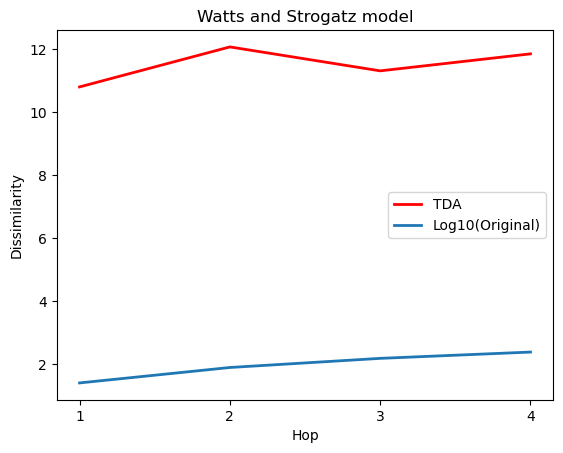

In [26]:
hop = ['1','2','3','4']
plt.plot(hop, TDA_avaerage,linewidth=2, markersize=12,color='red',label ="TDA")
plt.plot(hop, original_average,linewidth=2, markersize=12, label="Log10(Original)")
plt.xlabel('Hop')
plt.ylabel('Dissimilarity')
plt.title('Watts and Strogatz model')
plt.legend()
plt.savefig("TDA-Original-WS.jpg")
plt.show()